In [1]:
import numpy as np
import pandas as pd
import pyesg
from series import invest_series, salary_series, age_series, mortality_sim
from asset_mix import asset_mix

# projection inputs
yrs = 40                    # number of yrs to project
freq = 12                   # number of periods per year
n_scen = 10                 # number of scenarios

# demographic inputs
age = 30                    # starting age
sex = 'M'                   # sex
smoker = 'NS'               # SM for smoker NS for non-smoker
ret_age = 65                # age at which time investments into retirement fund cease and withdrawals begin
mi = .99                    # mortality improvement

# fund inputs
fund_value = 100000         # starting value of retirement fund
ret_inc = 1000000           # desired annual retirement income
salary = 100000             # starting salary
salary_growth = .045        # annual salary growth rate
invest_pct = .15            # pct of salary to be invested in retirement
inflation = .02             # annual inflation assumption
s_pct = .80                 # starting pct of funds to be invested in stocks
b_pct = 1 - s_pct           # starting pct of funds to be invested in bonds
pct_5 = .55                 # pct of funds to be invested in stocks 5 yrs out from retirement
s_pct_end = .2              # pct of funds to be invested in stocks at and during retirement
b_pct_end = 1 - s_pct_end   # pct of funds to be invested in bonds at and during retirement

# model inputs
x0 = 100.0                  # the start value of our process
dt = 1/freq                 # the length of each timestep in yrs
n_steps = freq * yrs        # the number of time steps per scenario
# random_state = 259        # optional random_state for reproducibility

config = {
    'yrs':yrs,
    'freq':freq,
    'n_scen':n_scen,
    'age':age,
    'sex':sex,
    'smoker':smoker,
    'ret_age':ret_age,
    'mi':mi,   
    'fund_value':fund_value,
    'ret_inc':ret_inc,
    'salary':salary,
    'salary_growth':salary_growth,
    'invest_pct':invest_pct,
    'inflation':inflation,
    's_pct':s_pct,
    'b_pct':b_pct,
    'pct_5':pct_5,
    's_pct_end':s_pct_end,
    'b_pct_end':b_pct_end,
    'x0':x0,
    'dt':dt,
    'n_steps':n_steps
}

# instantiate a new model with the required parameters
stock_model = pyesg.GeometricBrownianMotion(mu=0.10, sigma=0.15)
bond_model = pyesg.GeometricBrownianMotion(mu=0.05, sigma=0.05)

# run model for both equities and bonds
s_model_results = stock_model.scenarios(x0, dt, n_scen, n_steps)
b_model_results = bond_model.scenarios(x0, dt, n_scen, n_steps)

# create stock and bond index return arrays. 
stock_return = s_model_results[:, 1:] / s_model_results[:, :-1]
bond_return = b_model_results[:, 1:] / b_model_results[:, :-1]

# set beginning of fund array to starting investment value
stock_array = np.insert(stock_return, 0, fund_value * s_pct, axis=1)
bond_array = np.insert(bond_return, 0, fund_value * b_pct, axis=1)

# the last return value is not used so we add a 1 to the end to return the array to its original length
ones_to_append = np.ones((stock_return.shape[0], 1), dtype=int)
stock_return = np.append(stock_return, ones_to_append, axis=1)
bond_return = np.append(bond_return, ones_to_append, axis=1)

# create pandas series for various calcs
salary_s = salary_series(**config)
invest_s = invest_series(**config)
mortality_s = mortality_sim(**config)
asset_mix_s = asset_mix(**config)            
age_s = age_series(**config)

# this is where the magic happens
# calc the fund value at each point in time, credit interest, add/withdraw from fund
for s, b, inv, alloc_s, alloc_b in zip(stock_array, bond_array, invest_s, asset_mix_s['stock'], asset_mix_s['bond']):
    for i in range(1, len(s)):
        s[i] = s[i-1] * s[i]                            # stock fund @t = stock fund @t-1 * stock return
        b[i] = b[i-1] * b[i]                            # bond fund @t = bond fund @t-1 * bond return
        total_fund = s[i] + b[i] + invest_s[i-1]/freq   # total fund = stock + bond fund +/- investment
        s[i] = total_fund * alloc_s                     # reallocate fund value to stock fund
        b[i] = total_fund * alloc_b                     # reallocate fund value to bond fund

total_fund = stock_array + bond_array
df = pd.DataFrame(total_fund.T)

# with pd.ExcelWriter('Outputs/retirement_calc.xlsx') as writer:
#     df.to_excel(writer, sheet_name='sheet1')

In [4]:
print(df)

                0             1              2             3              4  \
0    1.000000e+05  1.000000e+05  100000.000000  1.000000e+05  100000.000000   
1    1.069919e+05  1.037749e+05  100248.937431  1.017741e+05   98871.489913   
2    1.074009e+05  1.035760e+05  102501.660829  9.996944e+04  100876.432840   
3    1.133043e+05  1.015682e+05  104992.904073  1.018710e+05   99914.840821   
4    1.186528e+05  1.028170e+05  110540.496825  9.250790e+04  104664.739316   
..            ...           ...            ...           ...            ...   
476  2.449025e+06  3.028114e+06  983465.049885  4.481752e+06  386163.044528   
477  2.458977e+06  3.179042e+06  891930.162417  4.446064e+06  400864.899365   
478  2.622915e+06  3.409317e+06  941708.135604  4.470912e+06  356763.379969   
479  2.617418e+06  3.264264e+06  929585.881098  4.571442e+06  343114.444006   
480  2.559654e+06  3.369382e+06  951044.327414  4.926714e+06  350700.729942   

                5             6             7      

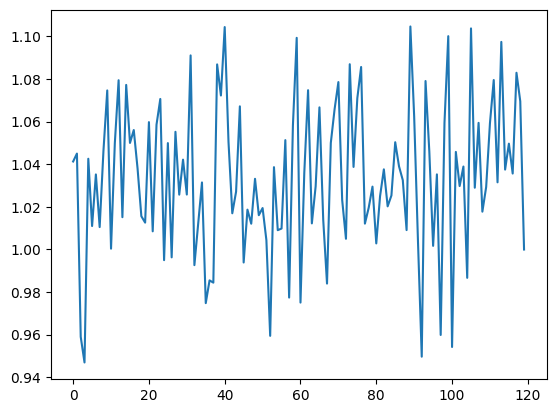

In [30]:
import pyesg
import matplotlib.pyplot as plt

hp = pyesg.HestonProcess(mu=0.05, kappa=0.8, sigma=0.001, theta=0.05, rho=-0.5)
br = pyesg.GeometricBrownianMotion(mu=0.06, sigma=0.05)
br_2 = pyesg.GeometricBrownianMotion(mu=0.06, sigma=0.05)

x0 = 100.0                  # the start value of our process
dt = 1/2             # the length of each timestep in yrs
n_steps = 12 * 10  
n_scen = 1    # the number of time steps per scenario
# random_state = 259        # optional random_state for reproducibility

hp_model_results = hp.scenarios(x0, dt, n_scen, n_steps)
br2_model_results = br_2.scenarios(x0, dt, n_scen, n_steps)

bond_return = br2_model_results[:, 1:] / br2_model_results[:, :-1]

for line in bond_return:
    plt.plot(line)

plt.show()





In [8]:

import pandas as pd

df = pd.DataFrame(hp_model_results)

print(df)

ValueError: Must pass 2-d input. shape=(3, 481, 2)

In [10]:
from dataclasses import dataclass

@dataclass
class Circle:
    radius: float
    area: float = 0.0

    def __post_init__(self):
        self.area = 3.14 * (self.radius ** 2)

In [33]:
# importing the yfinance package
import yfinance as yf

# giving the start and end dates
startDate = '2015-03-01'
endDate = '2023-09-01'

# setting the ticker value
ticker = 'VBTLX'

# downloading the data of the ticker value between
# the start and end dates
resultData = yf.download(ticker, startDate, endDate)

# printing the last 5 rows of the data
print(resultData.tail(200))

[*********************100%%**********************]  1 of 1 completed
            Open  High   Low  Close  Adj Close  Volume
Date                                                  
2022-11-14  9.39  9.39  9.39   9.39   9.278738       0
2022-11-15  9.45  9.45  9.45   9.45   9.338026       0
2022-11-16  9.51  9.51  9.51   9.51   9.397315       0
2022-11-17  9.46  9.46  9.46   9.46   9.347906       0
2022-11-18  9.45  9.45  9.45   9.45   9.338026       0
...          ...   ...   ...    ...        ...     ...
2023-08-25  9.35  9.35  9.35   9.35   9.350000       0
2023-08-28  9.37  9.37  9.37   9.37   9.370000       0
2023-08-29  9.43  9.43  9.43   9.43   9.430000       0
2023-08-30  9.42  9.42  9.42   9.42   9.420000       0
2023-08-31  9.44  9.44  9.44   9.44   9.440000       0

[200 rows x 6 columns]
